In [158]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import gzip
import os

In [159]:
# set names to the paths because they're too long
data_path = "C:\\Users\\LENOVO\Downloads\\"
# train path
train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')
# test path
test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

In [160]:
def get_mnist_data(images_path, labels_path, num_images
, shuffle=False, _is=True, image_size=28):
    """
    This shuffle param is active when .gz is downloaded at:
    - 'http://yann.lecun.com/exdb/mnist/'
    - This function return random num_images in 60000 or 10000
    """
    # read data
    # open file training to read training data
    f_images = gzip.open(images_path,'r')
    # skip 16 first bytes because these are not data, only header infor
    f_images.read(16)
    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 test)
    real_num = num_images if not shuffle else (60000 if _is else 10000)
    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)
    # images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)
    # Read labels
    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)
    labels = np.zeros((real_num)).astype(np.int64)
    # rearrange to correspond the images and labels
    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)
    # shuffle to get random images data
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)
        images = images[rand_id, :]
        labels = labels[rand_id,]
    # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
    return images, labels

In [161]:
images, labels = get_mnist_data(train_images_path, train_labels_path, 5000, shuffle=True)
images = StandardScaler().fit_transform(images)
pca = PCA(n_components= 100)
images_transform = pca.fit_transform(images)
X_train, X_test, Y_train, Y_test = train_test_split(images_transform, labels, test_size=0.3, random_state=25)
X_train = X_train.T
X_test = X_test.T
print(X_train.shape)

(100, 3500)


<Figure size 640x480 with 0 Axes>

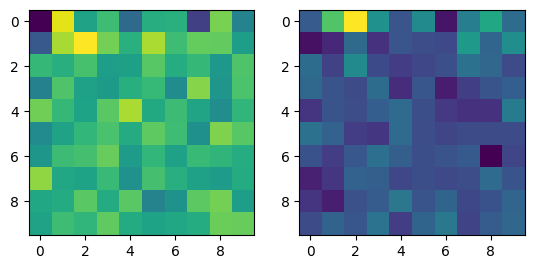

In [162]:
# for display and test digit :D
def get_image(image):
    return image.reshape(10, 10)
import random
import matplotlib.pyplot as plt
index = random.randint(0, 99)
train_image = np.asarray(get_image(X_train[:, index])).squeeze()
test_image = np.asarray(get_image(X_test[:, index])).squeeze()
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(train_image)
axarr[1].imshow(test_image)
plt.show()

In [163]:
def softmax(V):
    e_V = np.exp(V - np.max(V, axis = 0, keepdims = True))
    Z = e_V / e_V.sum(axis = 0)
    return Z

# cost or loss function
def cost(Y, Yhat):
    return -np.sum(Y*np.log(Yhat))/Y.shape[1]

## One-hot coding
from scipy import sparse
def convert_labels(y, C = 100):
    Y = sparse.coo_matrix((np.ones_like(y),
    (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y

In [164]:
d0 = 100
d1 = h = 100 # size of hidden layer

d2 = C = 10
# initialize parameters randomly
W1 = 0.01*np.random.randn(d0, d1)
b1 = np.zeros((d1, 1))
W2 = 0.01*np.random.randn(d1, d2)
b2 = np.zeros((d2, 1))

Y = convert_labels(Y_train, C)
N = X_train.shape[1]
eta = 1 # learning rate

In [165]:
for i in range(10000):
    ## Feedforward
    Z1 = np.dot(W1.T, X_train) + b1
    A1 = np.maximum(Z1, 0)
    Z2 = np.dot(W2.T, A1) + b2
    Yhat = softmax(Z2)

    # print loss after each 1000 iterations
    if i %1000 == 0:
        # compute the loss: average cross-entropy loss
        loss = cost(Y, Yhat)
        print("iter %d, loss: %f" %(i, loss))

    # backpropagation
    E2 = (Yhat - Y )/N
    dW2 = np.dot(A1, E2.T)
    db2 = np.sum(E2, axis = 1, keepdims = True)
    E1 = np.dot(W2, E2)
    E1[Z1 <= 0] = 0 # gradient of ReLU
    dW1 = np.dot(X_train, E1.T)
    db1 = np.sum(E1, axis = 1, keepdims = True)
    # Gradient Descent update
    W1 += -eta*dW1
    b1 += -eta*db1
    W2 += -eta*dW2
    b2 += -eta*db2

iter 0, loss: 2.303890
iter 1000, loss: 0.001503
iter 2000, loss: 0.000591
iter 3000, loss: 0.000352
iter 4000, loss: 0.000246
iter 5000, loss: 0.000188
iter 6000, loss: 0.000150
iter 7000, loss: 0.000125
iter 8000, loss: 0.000106
iter 9000, loss: 0.000093


In [166]:
Z1 = np.dot(W1.T, X_train) + b1
A1 = np.maximum(Z1, 0)
Z2 = np.dot(W2.T, A1) + b2
predicted_class = np.argmax(Z2, axis=0)
acc = 100*np.mean(predicted_class == Y_train)
print('training accuracy: %.2f %%' % (acc))

training accuracy: 100.00 %


In [167]:
Z1 = np.dot(W1.T, X_test) + b1
A1 = np.maximum(Z1, 0)
Z2 = np.dot(W2.T, A1) + b2
predicted_class = np.argmax(Z2, axis=0)
acc = 100*np.mean(predicted_class == Y_test)
print('testing accuracy: %.2f %%' % (acc))

testing accuracy: 93.00 %
